## Spatial statistics and generalised interpolation

Notebook investigating multidimensional interpolation, including Radial Basis Functions (RBF) and Kriging examples

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### Linear weighting

Consider the real function $f(X)$ where $X$ is a vector in an m-dimensional space. Take also a set of points $X_i$ with $i$ running from $1$ to $N$. We can form the vector $F$ with $F_i = f(X_i)$.

Define the estimated function $g(X) = \sum_{i=1}^N W_i(X) F_i = W(X).F$, where $W(X)$ is a vector of weights; in general these weights are a function of $X$. One-dimensional linear interpolation, for example, corresponds to the case where $m=1$ and the weights are determined by distances to the nearest neighbour(s).

Two cases of interest are RBF and Kriging. The general approach is to define the function $f(X)$, then a procedure for preparing the values needed to pass to a weight generating function that determines $W(X)$; in other words precalculation of the parameters used within $W(X)$ is desirable for efficiency. 

### RBF

Radial basis functions are based around a kernel function $k(A,B)$ that represents some idea of the distance between points $A$ and $B$. In general the kernel function is symmetric, so $k(A,B) = k(B,A)$, and also translationally invariant, so $k(A,B) = \phi(A-B)$.

Consider the function $h(X) = \sum_i k(X,X_i) \alpha_i$ for a vector $\alpha$ of factors, one for each point $X_i$. Then we can form $H$ according to $H_i = h(X_i)$, and then find the factors $\alpha$ that minimize the regularized
likelihood $L = -\frac{1}{2}\left(F-H\right)^2 + \frac{\lambda}{2}\left(\alpha K \alpha\right)$, where the matrix $K$ has been formed as $K_{ij} = k(X_i,X_j)$, so $H = K.\alpha$.

Minimizing the likelihood yields $\alpha = \left(K-\lambda\right)^{-1} F$. Note that this means that the estimated function is of the linear weighting form described above.

In [250]:
def simple_kernel(a,b):
    diff = a-b
    len2 = np.dot(diff,diff)
    return 1.0/(1.0+0.5*len2)

In [251]:
a1 = np.array([1,2,0])
b1 = np.array([1,-2,0])
simple_kernel(a1,b1)

0.1111111111111111

In [252]:
simple_kernel(a1,a1)

1.0

In [253]:
def function(x):
    return x[1]*x[0] + np.log(x[0]+0.001)+x[2]*x[2]*x[2]

In [254]:
test_points = pd.DataFrame([[1,2,3],
                           [4,5,6],
                           [0,0,0],
                           [1,0,0]])
test_points

,0,1,2
0,1,2,3
1,4,5,6
2,0,0,0
3,1,0,0


In [316]:
def form_rbf_artifacts(function, kernel, points, lambd = 0):
    # Form the F vector
    pointValues = points.apply(function,axis=1)
    numPoints = len(points)
    # Form the kernel matrix K
    cMat = np.zeros(shape=(numPoints,numPoints))
    for i in range(numPoints):
        iRow = np.array(points.iloc[i])
        for j in range(i,numPoints):
            cMat[i,j] = kernel(iRow,points.iloc[j])
            cMat[j,i] = cMat[i,j]
    resolv = cMat - (lambd*np.identity(numPoints))
    resInv = np.linalg.inv(resolv)
    alpha = np.matmul(resInv, pointValues)
    def points_estimator(x,kernel,points,**kwargs):
        #def kBind(pointsRow):
        #    return kernel(x,pointsRow)
        #return points.apply(kBind,axis=1)
        return points.apply(lambda pointsRow: kernel(x,pointsRow),axis=1)
    def estimator(x,alpha,**kwargs):
        kVec = points_estimator(x,**kwargs)
        return np.dot(kVec,alpha)
        
    return estimator , {
        'kernel':kernel,
        'function':function,
        'pointValues':pointValues,
        'points':points,
        'lambda':lambd,
        'alpha':alpha,
        'resInv':resInv,
        'points_estimator':points_estimator,
    }

In [317]:
estimator, kwargs = form_rbf_artifacts(function, simple_kernel, test_points)

In [318]:
estimator(np.array([3,4,5]),**kwargs)

96.226808734351479

In [319]:
estimator([1,2,3],**kwargs)

29.00099950033308

In [320]:
estimator(test_points.iloc[0],**kwargs)

29.00099950033308

In [321]:
kwargs['pointValues']

0     29.001000
1    237.386544
2     -6.907755
3      0.001000
dtype: float64

## One dimensional test function

We use $f(x) = x^4 - 5$

In [322]:
func1D = lambda x: (x*x*x*x -5)

In [323]:
func1DEst, kwargs = form_rbf_artifacts(func1D, simple_kernel, pd.DataFrame([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]))

In [324]:
xVec = np.arange(-400,400) / 100

In [325]:
vals = [func1DEst(x,**kwargs) for x in xVec]
actVals = [func1D(x) for x in xVec]
ratio = [v/a for v,a in zip(vals,actVals)]

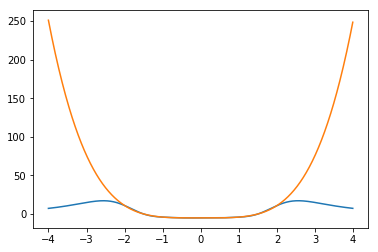

In [326]:
plt.plot(xVec,vals)
plt.plot(xVec,actVals)


(0.7, 1.3)

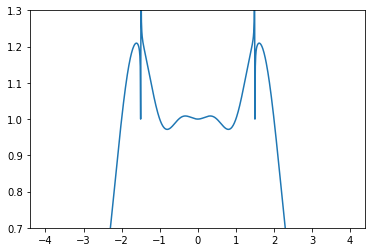

In [327]:
plt.plot(xVec,ratio)
axes = plt.gca()
axes.set_ylim([0.7,1.3])

In [330]:
resInv = kwargs['resInv']
for x in [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,0.99,0.9,0.75]:
    p = np.matmul(kwargs['points_estimator'](x,**kwargs),resInv)
    print(p)
                 

[  1.00000000e+00   3.58046925e-15  -3.02535774e-15   5.88418203e-15
   4.32986980e-15   1.77635684e-15  -2.88657986e-15  -8.88178420e-16
  -4.44089210e-16]
[  1.74860126e-15   1.00000000e+00   9.65894031e-15   3.33066907e-16
   1.05471187e-14  -6.88338275e-15  -2.22044605e-15  -2.22044605e-15
   1.11022302e-15]
[  1.29063427e-15   9.99200722e-16   1.00000000e+00  -3.33066907e-15
   4.21884749e-15   5.55111512e-15   8.88178420e-16  -8.88178420e-16
  -4.44089210e-16]
[  1.12410081e-15  -2.22044605e-15   2.22044605e-16   1.00000000e+00
   5.55111512e-15  -4.44089210e-15   7.54951657e-15  -5.32907052e-15
   1.77635684e-15]
[ -2.35922393e-16   3.63598041e-15  -9.10382880e-15   1.24344979e-14
   1.00000000e+00  -5.32907052e-15   8.88178420e-15   0.00000000e+00
  -1.77635684e-15]
[ -5.13478149e-16   1.16573418e-15  -7.77156117e-15   5.55111512e-15
   3.10862447e-15   1.00000000e+00  -1.77635684e-15   8.88178420e-15
  -6.21724894e-15]
[ -4.71844785e-16   1.66533454e-16  -4.44089210e-16   0.00